# Phylo-Prediction Stats Graphs
___

In [1]:
import os
#import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc, rcParams
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import mpl_toolkits.axisartist as AA
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import pickle

In [2]:
#from sklearn.metrics import r2_score
#from scipy import stats
#from scipy.stats import pearsonr

## Paths
___

In [3]:
project_path = os.path.join(os.getenv('HOME'),"Desktop","ml-ribo-predict")
results_path = os.path.join(project_path,"Results")

## Colormap

In [4]:
bottom = cm.get_cmap('Wistia', 128)
top = cm.get_cmap('Blues_r', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)), bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

## Data
___

In [5]:
def getRFdata(path, file):
    f = open(os.path.join(path,file), 'rb')
    d = pickle.load(f)
    f.close()
    return d

In [6]:
rf = getRFdata(os.path.join(results_path, "RF_80"),"rfresults.pickle")
rfpr = getRFdata(os.path.join(results_path, "RF_80"),"pred_results.pickle")
rfac = getRFdata(os.path.join(results_path, "RF_80"),"act_results.pickle")
lstmrf = getRFdata(os.path.join(results_path, "LSTM_RF"),"rfresults.pickle")
lstmrfpr = getRFdata(os.path.join(results_path, "LSTM_RF"),"pred_results.pickle")
lstmrfac = getRFdata(os.path.join(results_path, "LSTM_RF"),"act_results.pickle")

In [ ]:
# LSTM rows: number of variants in train, columns: predicted variant number
LSTM_counts = np.zeros((13,1)) 
LSTM_mse = np.zeros((13,13))
LSTM_r2 = np.zeros((13,13))
LSTM_pearson = np.zeros((13,13))

for i in range(1,14):
    mut_variant = f'{i}_predict.csv'
    df = pd.read_csv(os.path.join(results_path,"JB_Phylo2", mut_variant))
    LSTM_counts[i-1] = i
    
    for j in range(1,14):    
        LSTM_mse[i-1,j-1] = ((df[f'predict_{j}'] - df['label'])**2).mean()
        LSTM_r2[i-1,j-1] = (r2_score(df['label'],df[f'predict_{j}']))
        r, _ = pearsonr(df['label'],df[f'predict_{j}'])
        LSTM_pearson[i-1,j-1] = r 

In [ ]:
LSTM_pearson[0][0:7]

## Functions
___

In [8]:
def accumulatePredictions(file,test):
    mse,r2,p = np.empty(13),np.empty(13),np.empty(13)
    i=0

    for (k,v) in file.items(): 
        if k.split('_')[1] == test:
            mse[i] = v[0]
            r2[i] = v[1]
            p[i] = v[2]
            i+=1
            
    return mse, r2, p

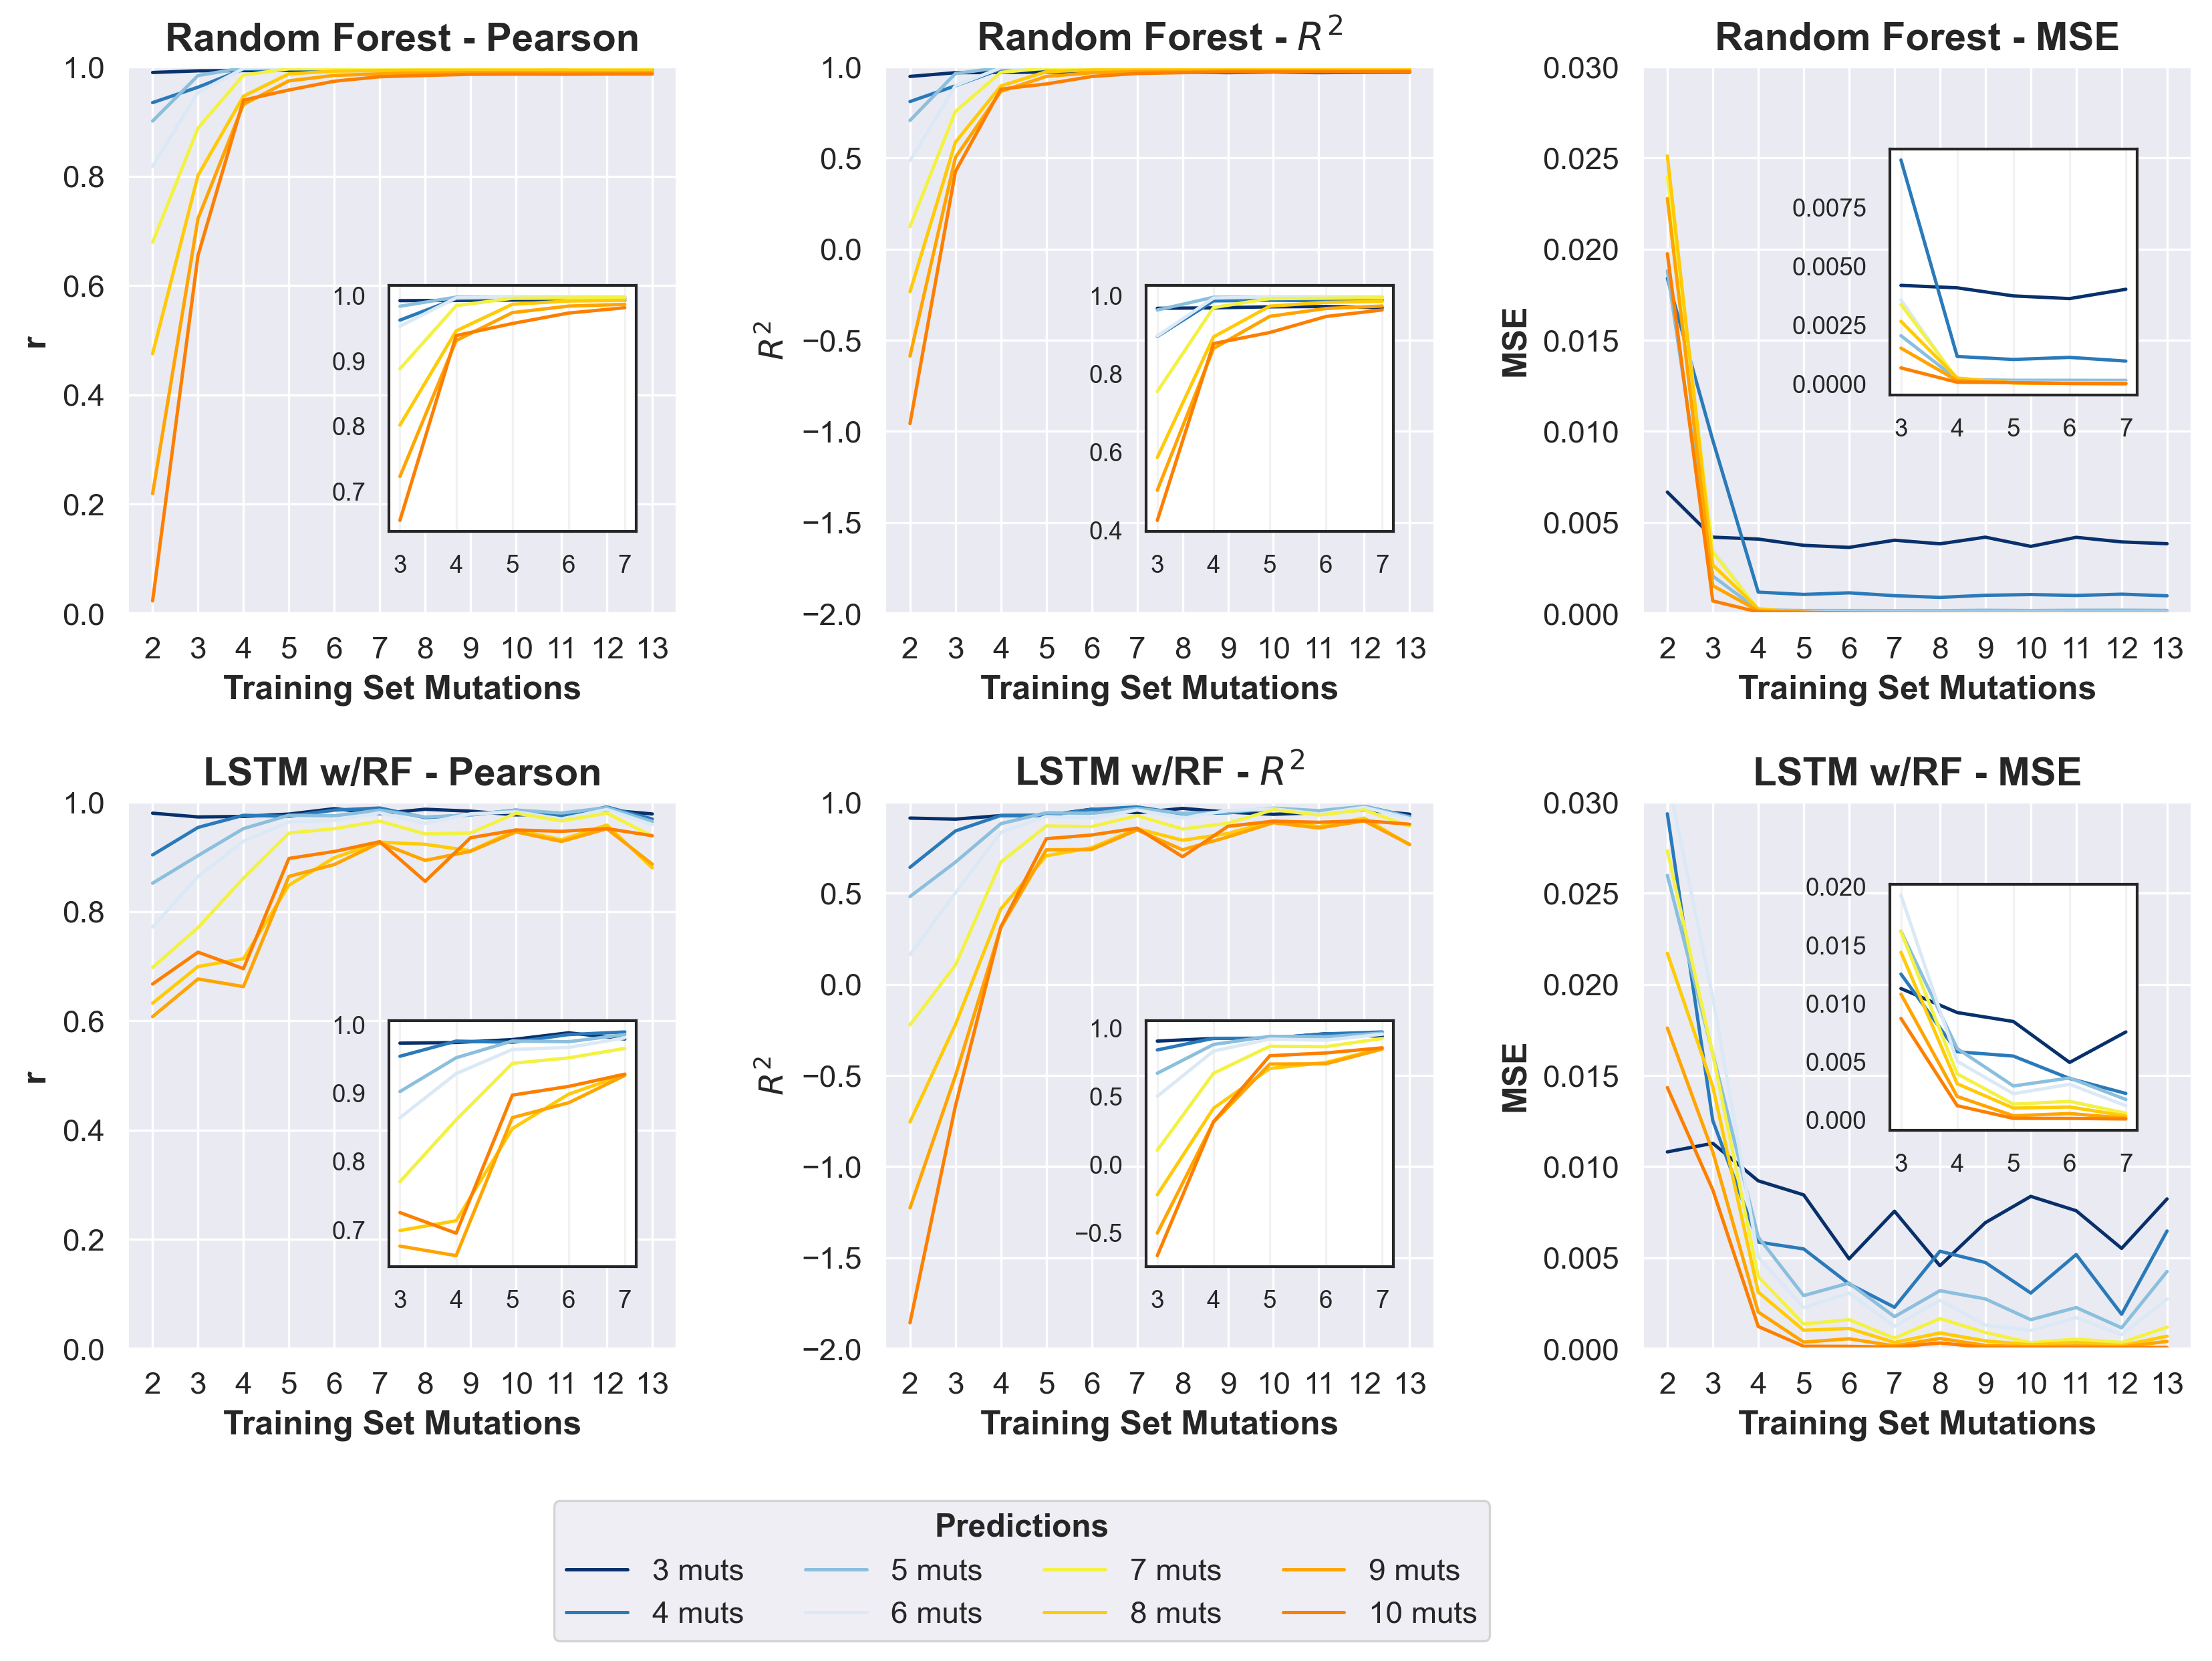

In [12]:
counts = list(range(1,14))
rows, cols = 2,3
fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(cols*4,rows*4), dpi=300)
fig.tight_layout(pad=5.0)
sns.set_style("darkgrid")
sns.set_context("paper")


test_start, test_stop = 2,10
ins_start, ins_stop = 3,7
train_start, train_stop = 1,13

with sns.axes_style("white"):   
    axins1 = ax[0,0].inset_axes((0.475, 0.15,.45,.45))
    axins2 = ax[0,1].inset_axes((0.475, 0.15,.45,.45))
    axins3 = ax[0,2].inset_axes((0.45, 0.4,.45,.45))
    axins4 = ax[1,0].inset_axes((0.475, 0.15,.45,.45))
    axins5 = ax[1,1].inset_axes((0.475, 0.15,.45,.45))
    axins6 = ax[1,2].inset_axes((0.45, 0.4,.45,.45))

colors = newcmp(np.linspace(0,1,8))

for r in range(0,rows):
    for c in range(0,cols):
        with sns.axes_style("white"):
            ax[r,0].set_ylim([0,1])
            ax[r,0].set_ylabel("r", fontsize=12, fontweight= 'bold')
            
            ax[r,1].set_ylim([-2,1])
            ax[r,1].set_ylabel("$R^2$", fontsize=12, fontweight= 'bold')
            
            ax[r,2].set_ylim([0,0.03])
            ax[r,2].set_ylabel("MSE", fontsize=12, fontweight= 'bold')
            
            ax[r,c].set_xticks(range(2,14))
            ax[r,c].tick_params(axis='both', which='major', labelsize=11)
            ax[r,c].set_xlabel("Training Set Mutations", fontsize=12, fontweight= 'bold')

ax[0,0].set_title("Random Forest - Pearson", fontsize = 14, fontweight = 'bold')
ax[0,1].set_title("Random Forest - $R^2$", fontsize = 14, fontweight = 'bold')
ax[0,2].set_title("Random Forest - MSE", fontsize = 14, fontweight = 'bold')
ax[1,0].set_title("LSTM w/RF - Pearson", fontsize = 14, fontweight = 'bold')
ax[1,1].set_title("LSTM w/RF - $R^2$", fontsize = 14, fontweight = 'bold')
ax[1,2].set_title("LSTM w/RF - MSE", fontsize = 14, fontweight = 'bold')

        
        
for i in range(test_start,test_stop):
    
    m1,r1,p1 = accumulatePredictions(rf, f"te{i}")
    m2,r2,p2 = accumulatePredictions(lstmrf, f"te{i}")
    
    ax[0,0].plot(counts[train_start:train_stop], p1[train_start:train_stop], label=f'LSTM - {i+1} muts',color=colors[i-2]) 
    
    ax[0,1].plot(counts[train_start:train_stop], r1[train_start:train_stop], label=f'LSTM - {i+1} muts',color=colors[i-2])
    
    ax[0,2].plot(counts[train_start:train_stop], m1[train_start:train_stop], label=f'LSTM - {i+1} muts',color=colors[i-2]) 
    
    ax[1,0].plot(counts[train_start:train_stop], p2[train_start:train_stop], label=f'RF - {i+1} muts', color=colors[i-2])
    
    ax[1,1].plot(counts[train_start:train_stop], r2[train_start:train_stop], label=f'RF - {i+1} muts', color=colors[i-2])
    
    ax[1,2].plot(counts[train_start:train_stop], m2[train_start:train_stop], label=f'{i+1} muts', color=colors[i-2])
    
    
    
    axins1.plot(counts[ins_start-1:ins_stop], p1[ins_start-1:ins_stop], label=f'LSTM - {i+1} muts',color=colors[i-2])
    axins1.set_xticks([3,4,5,6,7])
    axins1.grid(axis='x', color='0.95')
    
    axins2.plot(counts[ins_start-1:ins_stop], r1[ins_start-1:ins_stop], label=f'LSTM - {i+1} muts',color=colors[i-2])
    axins2.set_xticks([3,4,5,6,7])
    axins2.grid(axis='x', color='0.95')
    
    axins3.plot(counts[ins_start-1:ins_stop], m1[ins_start-1:ins_stop], label=f'LSTM - {i+1} muts',color=colors[i-2])
    axins3.set_xticks([3,4,5,6,7])
    axins3.grid(axis='x', color='0.95')

    axins4.plot(counts[ins_start-1:ins_stop], p2[ins_start-1:ins_stop], label=f'LSTM - {i+1} muts',color=colors[i-2])
    axins4.set_xticks([3,4,5,6,7])
    axins4.grid(axis='x', color='0.95')
    
    axins5.plot(counts[ins_start-1:ins_stop], r2[ins_start-1:ins_stop], label=f'LSTM - {i+1} muts',color=colors[i-2])
    axins5.set_xticks([3,4,5,6,7])
    axins5.grid(axis='x', color='0.95')
    
    axins6.plot(counts[ins_start-1:ins_stop], m2[ins_start-1:ins_stop], label=f'LSTM - {i+1} muts',color=colors[i-2])
    axins6.set_xticks([3,4,5,6,7])
    axins6.grid(axis='x', color='0.95')

    
lg = plt.legend(title ="Predictions",title_fontproperties = {'size':'large','weight':'bold'},bbox_to_anchor=(-0.25, -0.25), ncol=4, fontsize = 11)

# plt.savefig(os.path.join(project_path,'Images','All_metrics.jpg'), 
#             dpi=300, 
#             format='png', 
#             bbox_extra_artists=(lg,), 
#             bbox_inches='tight')

plt.show()